In [2]:
import tensorflow as tf

In [24]:
from tensorflow.keras.layers import LSTM,Dense,Embedding,Input,Bidirectional,Dropout

In [5]:
from tensorflow.keras import Model

In [8]:
max_inp_len=2
max_tar_len=5
inp_vocab_size=4
trg_vocab_size=7
lstm_units=8
embed_size=15

In [9]:
class LuongGlobalAttention(tf.keras.layers.Layer):
    def __init__(self,units,method="Dot"):
        super(LuongGlobalAttention,self).__init__()
        self.method=method
        self.w1=Dense(units,use_bias=False)
        if method=="Concat":
            self.weight = tf.Variable(initial_value=tf.zeros((units,1)), trainable=True, dtype=tf.float32)

    def call(self,inputs):
        encoder_op,decoder_op=inputs
        if self.method=="General":
            decoder_op=tf.transpose(decoder_op,perm=(0,2,1))
            ou1=self.w1(encoder_op)
            score=tf.matmul(ou1,decoder_op)

        elif self.method=="Dot":
            decoder_op=tf.transpose(decoder_op,perm=(0,2,1))
            score=tf.matmul(encoder_op,decoder_op)

        elif self.method=="Concat":
            concat=tf.nn.tanh(self.w1(encoder_op)+self.w1(decoder_op))
            score=tf.matmul(concat,self.weight)

        else:
            try:
                raise ValueError("Try valid alignment")
            except ValueError as e:
                print("Error:", e)
                return

        attention_weights=tf.nn.softmax(score,axis=1)
        attention_weights=tf.transpose(attention_weights,perm=(0,2,1))
        context_vector=tf.matmul(attention_weights,encoder_op)
        return context_vector

In [139]:
encoder_inputs=Input(shape=(max_inp_len,))
encoder_embedded=Embedding(inp_vocab_size,embed_size)
encoder_embed=encoder_embedded(encoder_inputs)
encoder_dropout=Dropout(rate=0.3)

encoder_lstm1=Bidirectional(LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
encoder_lstm1_output,forward_h,forward_c,backward_h,backward_c=encoder_lstm1(encoder_embed)
encoder_lstm1_output=encoder_dropout(encoder_lstm1_output)

h=tf.concat([forward_h,backward_h],axis=-1)
c=tf.concat([forward_c,backward_c],axis=-1)

encoder_dense=Dense(lstm_units)

h=encoder_dense(h)
c=encoder_dense(c)


encoder_lstm2=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
encoder_lstm2_output,h,c=encoder_lstm2(encoder_lstm1_output,initial_state=[h,c])
encoder_lstm2_output=encoder_dropout(encoder_lstm2_output)

encoder_lstm3=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
encoder_lstm3_output,h,c=encoder_lstm3(encoder_lstm2_output,initial_state=[h,c])
encoder_lstm3_output=encoder_dropout(encoder_lstm3_output)

encoder_lstm_combined=encoder_lstm2_output+encoder_lstm3_output

encoder_lstm4=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
encoder_lstm4_output,h,c=encoder_lstm4(encoder_lstm_combined,initial_state=[h,c])
encoder_lstm4_output=encoder_dropout(encoder_lstm4_output)

decoder_inputs=Input(shape=(None,))
decoder_embedded=Embedding(trg_vocab_size,embed_size)
decoder_embed=decoder_embedded(decoder_inputs)
decoder_dropout=Dropout(rate=0.3)

decoder_lstm1=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
decoder_lstm1_output,h1,c1=decoder_lstm1(decoder_embed,initial_state=[h,c])
decoder_lstm1_output=decoder_dropout(decoder_lstm1_output)

decoder_lstm2=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
decoder_lstm2_output,h1,c1=decoder_lstm2(decoder_lstm1_output,initial_state=[h1,c1])
decoder_lstm2_output=decoder_dropout(decoder_lstm2_output)


decoder_lstm3=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
decoder_lstm3_output,h1,c1=decoder_lstm3(decoder_lstm2_output,initial_state=[h1,c1])
decoder_lstm3_output=decoder_dropout(decoder_lstm3_output)


decoder_lstm_combined=decoder_lstm2_output+decoder_lstm3_output

decoder_lstm4=LSTM(lstm_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
decoder_lstm4_output,h1,c1=decoder_lstm4(decoder_lstm_combined,initial_state=[h1,c1])
decoder_lstm4_output=decoder_dropout(decoder_lstm4_output)


attention=LuongGlobalAttention(lstm_units,method="Dot")
context_vector=attention([encoder_lstm4_output,decoder_lstm4_output])

decoder_op=tf.concat([context_vector, decoder_lstm4_output],axis=-1)
decoder_op=tf.nn.tanh(decoder_op)
decoder_dense=Dense(trg_vocab_size,activation='softmax')
decoder_op=decoder_dense(decoder_op)

model=Model([encoder_inputs,decoder_inputs],decoder_op)

In [140]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 2, 15)                60        ['input_9[0][0]']             
                                                                                                  
 bidirectional_4 (Bidirecti  [(None, 2, 16),              1536      ['embedding_8[0][0]']         
 onal)                        (None, 8),                                                          
                              (None, 8),                                                          
                              (None, 8),                                                    

                                                                                                  
Total params: 6244 (24.39 KB)
Trainable params: 6244 (24.39 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [141]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.007,clipnorm=5)

In [164]:
def masked_loss(y_true,y_pred):
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
    loss=loss_fn(y_true,y_pred)
    mask=tf.cast(y_true!=0,loss.dtype)
    loss*=mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [165]:
def masked_accuracy(y_true,y_pred):
    y_pred=tf.argmax(y_pred,axis=-1)
    y_pred=tf.cast(y_pred,y_true.dtype)
    match=tf.cast(y_pred==y_true,tf.float32)
    mask=tf.cast(y_true!=0,tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [166]:
model.compile(optimizer=optimizer,loss=masked_loss,metrics=[masked_accuracy,masked_loss])

In [167]:
import numpy as np
x=np.random.random((10,max_inp_len))
y=np.random.random((10,max_tar_len))

In [168]:
x1=np.random.random((2,max_inp_len))
y1=np.random.random((2,max_tar_len))

In [169]:
y1_onehot=tf.one_hot(y1,trg_vocab_size)

In [170]:
y1_onehot.shape

TensorShape([2, 5, 7])

In [171]:
y_onehot=tf.one_hot(y,trg_vocab_size)

In [172]:
y_onehot.shape

TensorShape([10, 5, 7])

In [173]:
history=model.fit([x,y],y,epochs=4,validation_data=([x1,y1],y1))

Epoch 1/4
1/1 [==============================] - 51s 51s/step - loss: 1.0535 - masked_accuracy: 0.0000e+00 - masked_loss: 1.0535 - val_loss: 0.7759 - val_masked_accuracy: 0.0000e+00 - val_masked_loss: 0.7759
Epoch 2/4
1/1 [==============================] - 0s 100ms/step - loss: 0.8249 - masked_accuracy: 0.0000e+00 - masked_loss: 0.8249 - val_loss: 0.5843 - val_masked_accuracy: 0.0000e+00 - val_masked_loss: 0.5843
Epoch 3/4
1/1 [==============================] - 0s 98ms/step - loss: 0.6476 - masked_accuracy: 0.0000e+00 - masked_loss: 0.6476 - val_loss: 0.4253 - val_masked_accuracy: 0.0000e+00 - val_masked_loss: 0.4253
Epoch 4/4
1/1 [==============================] - 0s 96ms/step - loss: 0.5126 - masked_accuracy: 0.0000e+00 - masked_loss: 0.5126 - val_loss: 0.3048 - val_masked_accuracy: 0.0000e+00 - val_masked_loss: 0.3048


In [174]:
import matplotlib.pyplot as plt
%matplotlib inline

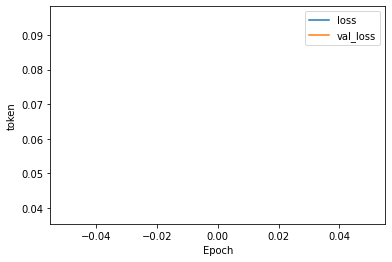

In [180]:
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("token")
plt.legend()

In [181]:
model.evaluate([x1,y1],y1)

1/1 [==============================] - 0s 159ms/step - loss: 0.0383 - masked_accuracy: 0.0000e+00 - masked_loss: 0.0383


[0.03825240582227707, 0.0, 0.03825240582227707]

In [179]:
import tensorflow as tf

adam_epochs = 5
sgd_epochs = 10
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=5)
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.2,clipnorm=5)


total_epochs = adam_epochs + sgd_epochs

for epoch in range(total_epochs):
    if epoch < adam_epochs:
        model.compile(optimizer=adam_optimizer, loss=masked_loss,metrics=[masked_accuracy,masked_loss])
    else:
        model.compile(optimizer=sgd_optimizer, loss=masked_loss,metrics=[masked_accuracy,masked_loss])  
        
    history=model.fit([x,y],y,epochs=1,validation_data=([x1,y1],y1))


1/1 [==============================] - 49s 49s/step - loss: 0.0954 - masked_accuracy: 0.0000e+00 - masked_loss: 0.0954 - val_loss: 0.0383 - val_masked_accuracy: 0.0000e+00 - val_masked_loss: 0.0383
